In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

# Важно! 

Я же неправильно начальные условия для воротных переменых указал, это может быть проблемой для возникновения спайка от короткого но высокоамплитудного тока!

## Минимальный набор

$$
\begin{cases}
\alpha_n = 0.032 \frac{15 - v + v_T}{\exp(\frac{15 - v + v_T}{5}) - 1} \\
\beta_n = 0.5 \exp(\frac{10 - v + v_T}{40}) \\
\alpha_m = 0.32 \frac{13 - v + v_T}{\exp(\frac{13 - v + v_T}{4}) - 1} \\
\beta_m = 0.28 \frac{v - v_T - 40}{\exp(\frac{v - v_T - 40}{5}) - 1} \\
\alpha_h = 0.128 \exp(\frac{17 - v + v_T}{18}) \\
\beta_h = \frac{4}{1 + \exp(\frac{40 - v + v_T}{5})}
\end{cases}
$$

In [75]:
start_scope()

Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brian examples

eqs = Equations("""
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I) / Cm : volt

I : ampere
""")

dndt = Equations("""
dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz
    """)
dmdt = Equations("""
dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
""")
dhdt = Equations("""
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz
""")

neuron = NeuronGroup(1, eqs+dndt+dmdt+dhdt, method='euler')

stmon = StateMonitor(neuron, ['v', 'h', 'm', 'n'], True)

neuron.v = El

store("init")

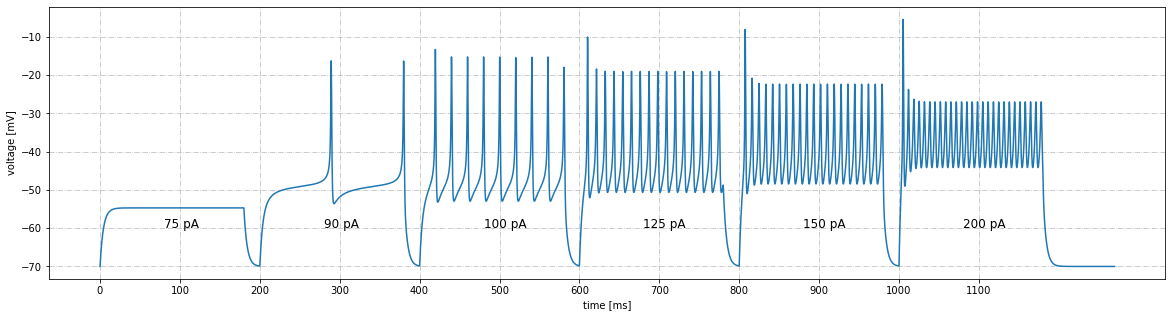

In [76]:
restore("init")

currs = [75, 90, 100, 125, 150, 200]

for i in currs:
    neuron.I = i * pA
    run(180*ms)
    neuron.I = 0 * pA
    run(20*ms)

run(70*ms)

figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV)
ylabel("voltage [mV]")
xlabel("time [ms]")
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("basic_spikes.jpeg", dpi=200)

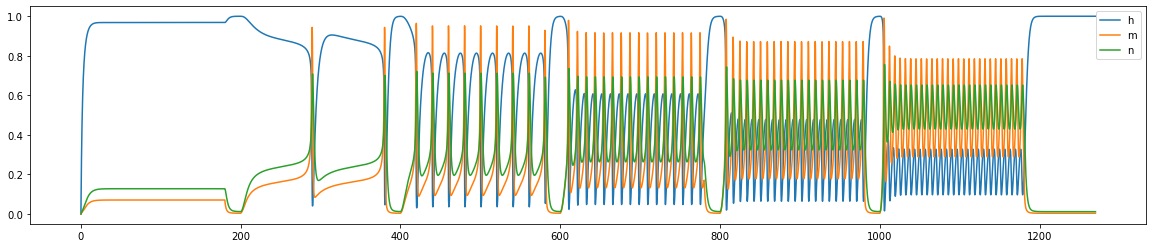

In [77]:
figure(figsize=(20, 4))
plot(stmon.t/ms, stmon.h[0])
plot(stmon.t/ms, stmon.m[0])
plot(stmon.t/ms, stmon.n[0])
legend(["h", "m", "n"])

## Попытка сгладить активность (сделать похоже на "реальные")

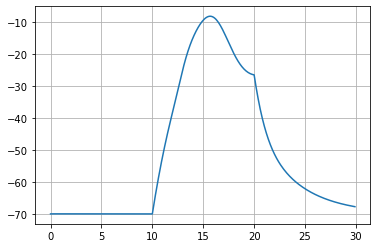

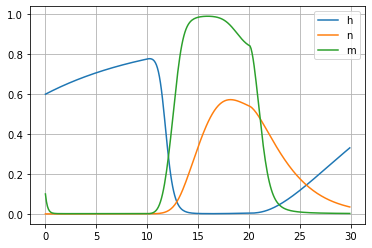

In [85]:
dndt_ = Equations("""
dn/dt = (n0 - n) / tau_n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT +15*mV)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT +15*mV)/40/mV) / ms : Hz
n0 = a_n / (a_n + b_n) : 1
tau_n = 1 / (a_n + b_n) * 3 : second
""")
dmdt_ = Equations("""
dm/dt = (m0 - m) / tau_m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT +5*mV)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV +5*mV)/5/mV) / ms : Hz
m0 = a_m / (a_m + b_m) : 1
tau_m = 1 / (a_m + b_m) * 3 : second
""")
dhdt_ = Equations("""
dh/dt = (h0 - h) / tau_h : 1
a_h = 0.128*exp((17*mV - v + VT -20*mV)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT -20*mV)/5/mV)) / ms : Hz
h0 = a_h / (a_h + b_h) : 1
tau_h = 1 / (a_h + b_h) * 2 : second
""")
neuron = NeuronGroup(1, eqs+dndt_+dmdt_+dhdt_, method='euler')
stmon = StateMonitor(neuron, ['v', 'm', 'h', 'n'], True)
neuron.h = 0.6
neuron.m = 0.1
neuron.v = El

run(10*ms)
neuron.I = 400 * pA
run(10*ms)
neuron.I = 0*nA
run(10*ms)

plot(stmon.t/ms, stmon.v[0]/mV)
grid()
figure()
plot(stmon.t/ms, stmon.h[0])
plot(stmon.t/ms, stmon.n[0])
plot(stmon.t/ms, stmon.m[0])
legend(["h", "n", "m"])
grid()

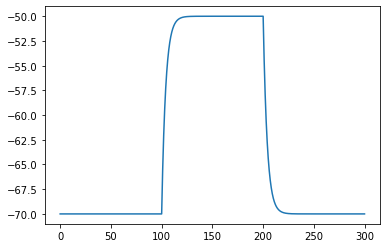

In [5]:
# only leaky
eqs = """
dv/dt = (gL * (El - v) + I) / Cm : volt

I : ampere
"""

neuron = NeuronGroup(1, eqs, method='euler')

stmon = StateMonitor(neuron, ['v'], True)

neuron.v = El

run(100*ms)
neuron.I = 0.1 * nA
run(100*ms)
neuron.I = 0 * nA
run(100*ms)

plot(stmon.t/ms, stmon.v[0]/mV)

# Синапсы

## Просто синапс (один к одному)

In [26]:
start_scope()

Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 0.5 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(2, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=0, j=1)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0] = i * pA
    run(180*ms)
    neuron.I[0] = 0 * pA
    run(20*ms)

run(70*ms)

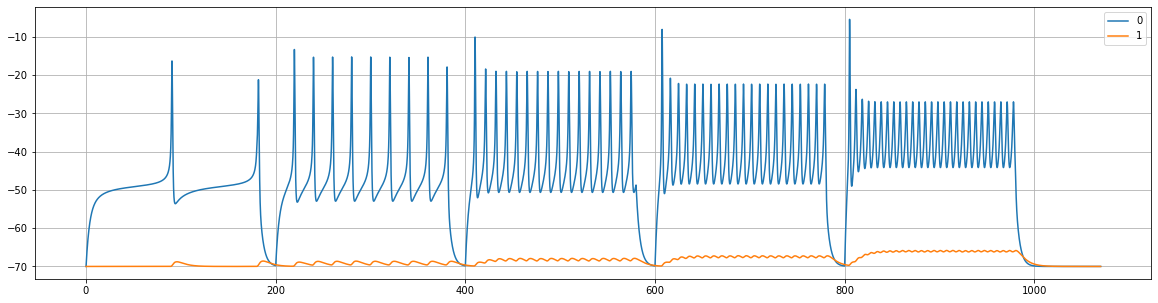

In [27]:
figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV, label='0')
plot(stmon.t/ms, stmon.v[1]/mV, label='1')
grid()
legend()

## Несколько нейронов к одному

In [8]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 0.5 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(11, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=range(0, 10), j=10)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0:11] = i * pA
    run(180*ms)
    neuron.I[0:11] = 0 * pA
    run(20*ms)

run(70*ms)

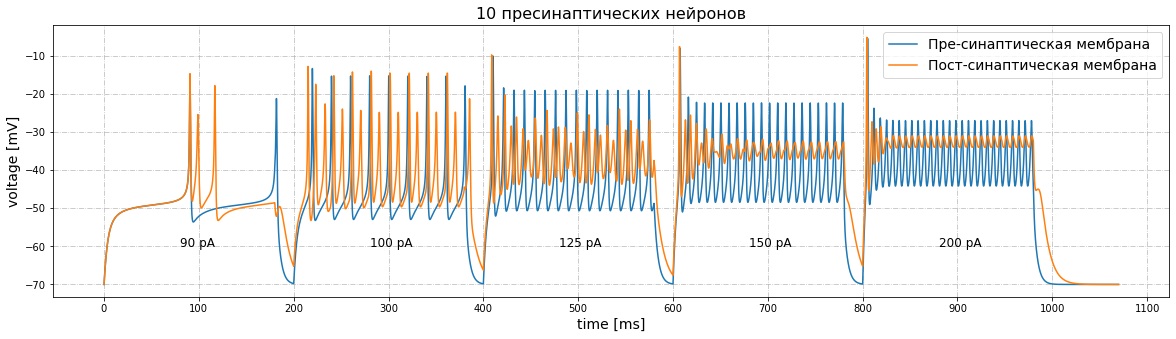

In [9]:
figure(figsize=(20, 5))
title("10 пресинаптических нейронов", fontsize=16)
plot(stmon.t/ms, stmon.v[0]/mV, label='Пре-синаптическая мембрана')
plot(stmon.t/ms, stmon.v[10]/mV, label='Пост-синаптическая мембрана')
grid()
legend(fontsize=14)
ylabel("voltage [mV]", fontsize=14)
xlabel("time [ms]", fontsize=14)
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("десять_к_одному.jpeg", dpi=200)

## Один к одному, много нейротрансмиттера

In [12]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 10 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(2, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=0, j=1)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0:11] = i * pA
    run(180*ms)
    neuron.I[0:11] = 0 * pA
    run(20*ms)

run(70*ms)

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.

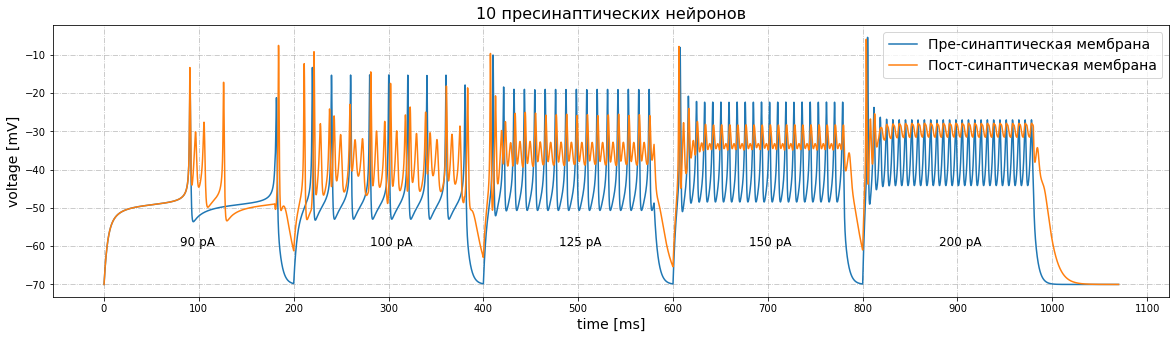

In [41]:
figure(figsize=(20, 5))
title("10 пресинаптических нейронов", fontsize=16)
plot(stmon.t/ms, stmon.v[0]/mV, label='Пре-синаптическая мембрана')
plot(stmon.t/ms, stmon.v[1]/mV, label='Пост-синаптическая мембрана')
grid()
legend(fontsize=14)
ylabel("voltage [mV]", fontsize=14)
xlabel("time [ms]", fontsize=14)
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("один_к_одному.jpeg", dpi=200)

## Подпороговая активность

Мы хотим сделать её более плавной, не такой резкой. Чтобы было похоже на экспериментальные данные.

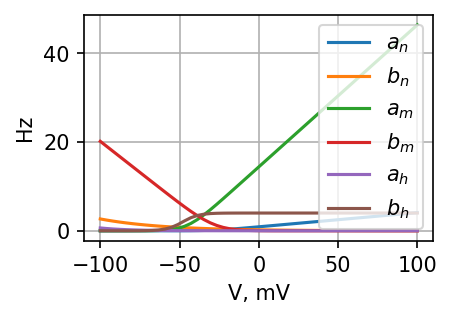

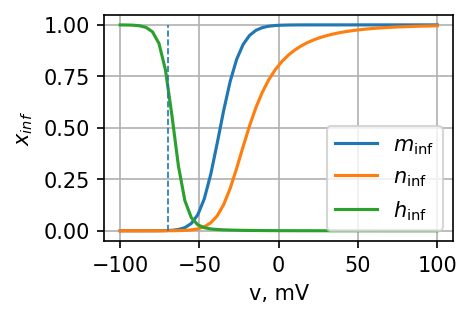

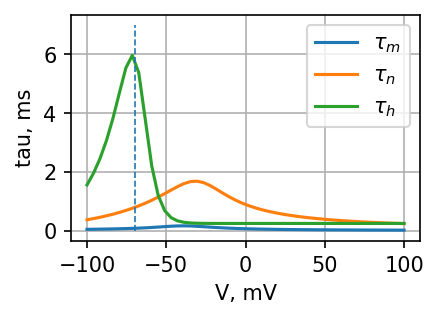

In [69]:
vv = np.linspace(-100, 100)
VT_ = -63 
an = 0.032 * 5 / exprel((15 - vv + VT_ +20)/5)  # remove +20
bn = 0.5 * exp((10 - vv + VT_ +20)/40)
n_inf = an / (an + bn)
tau_n = 1 / (an + bn)

am = 0.32 * 4 / exprel((13 - vv + VT_ +5)/4)  # remove -15
bm = 0.28 * 5 / exprel((vv - VT_ - 40 +5)/5)  # remove -15
m_inf = am / (am + bm)
tau_m = 1 / (am + bm)

ah = 0.128*exp((17 - vv + VT_ -25)/18)  # remove -15
bh = 4 / (1 + exp((40 - vv + VT_ -25)/5))  # remove -15
h_inf = ah / (ah + bh)
tau_h = 1 / (ah + bh)

figure(figsize=(3,2), dpi=150)
plot(vv, an, label='$a_n$')
plot(vv, bn, label='$b_n$')
plot(vv, am, label='$a_m$')
plot(vv, bm, label='$b_m$')
plot(vv, ah, label='$a_h$')
plot(vv, bh, label='$b_h$')
grid()
ylabel('Hz')
xlabel('V, mV')
legend()

figure(figsize=(3,2), dpi=150)
plot(vv, m_inf, label='$m_{\inf}$')
plot(vv, n_inf, label='$n_{\inf}$')
plot(vv, h_inf, label='$h_{\inf}$')
vlines(-70, 0, 1, ls="--", lw=.8)
grid()
ylabel("$x_{inf}$")
xlabel("v, mV")
legend();

figure(figsize=(3,2), dpi=150)
plot(vv, tau_m)
plot(vv, tau_n)
plot(vv, tau_h)
grid()
vlines(-70, 0, 7, ls="--", lw=.8)
ylabel('tau, ms')
xlabel('V, mV')
legend([f"$\\tau_{x}$" for x in ['m', 'n', 'h']]);

In [74]:
start_scope()
Cm = 20*pF

test_eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

#dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dn/dt = -(n - n0) / tau_n : 1
n0 = a_n / (a_n + b_n) : 1
tau_n = 1 / (a_n + b_n) : second

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz

#dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz
dh/dt = -(h - h0) / tau_h : 1
h0 = a_h / (a_h + b_h) : 1
tau_h = 1 / (a_h + b_h) + 3*ms : second

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

test = NeuronGroup(1, eqs, method='euler')
testmon = StateMonitor(test, ['v', 'n', 'm', 'h', 'tau_n'], True)

test.v = El

for j in [120, 200]*pA:
    test.I = j
    run(30*ms)
    test.I = 0*pA
    run(50*ms)

$$ \tau = \frac{1}{\alpha + \beta} $$

$$ \tau + 5ms = \frac{1}{\alpha + \beta} + 5ms = \frac{1}{\alpha^{'} + \beta^{'}} $$

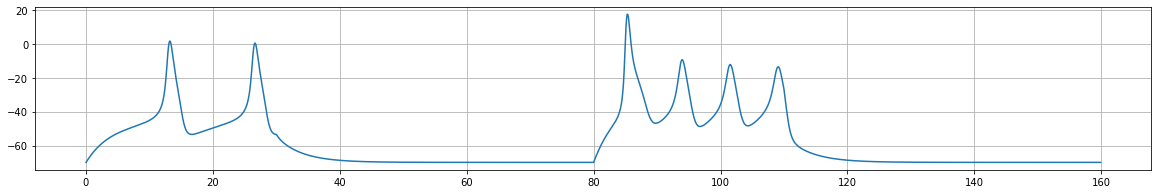

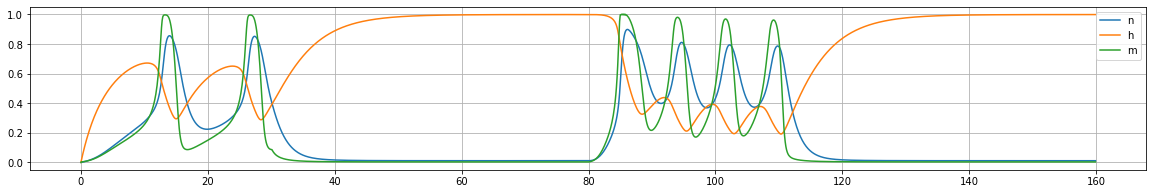

In [73]:
# modified, 
figure(figsize=(20, 3))
plot(testmon.t/ms, testmon.v[0]/mV)
grid()
figure(figsize=(20,3))
plot(testmon.t/ms, testmon.n[0], label='n')
plot(testmon.t/ms, testmon.h[0], label='h')
plot(testmon.t/ms, testmon.m[0], label='m')
grid()
legend()

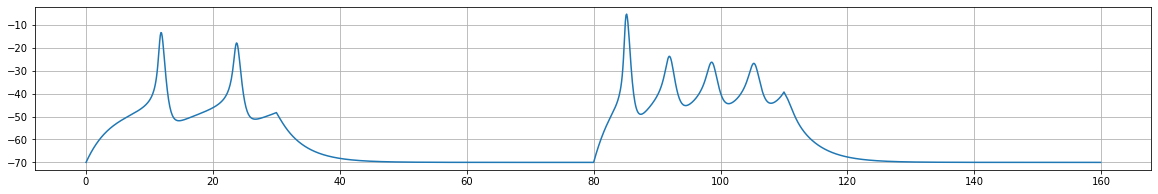

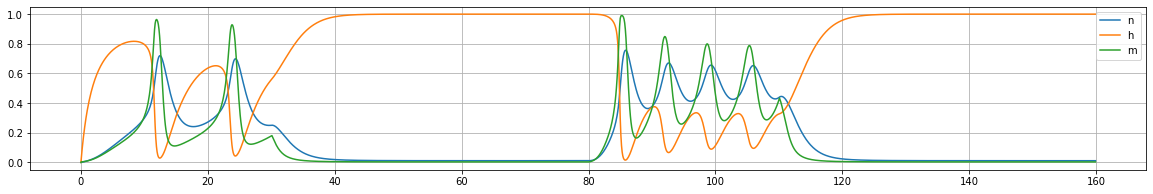

In [44]:
figure(figsize=(20, 3))
plot(testmon.t/ms, testmon.v[0]/mV)
grid()
figure(figsize=(20,3))
plot(testmon.t/ms, testmon.n[0], label='n')
plot(testmon.t/ms, testmon.h[0], label='h')
plot(testmon.t/ms, testmon.m[0], label='m')
grid()
legend()

## Зависимость частоты от входящего тока

In [84]:
start_scope()

N = 100

if_group = NeuronGroup(N, test_eqs, method="euler", threshold="v > -40*mV", refractory="v > -40*mV")

if_mon = SpikeMonitor(if_group)

if_group.v = -70*mV
if_group.I = "i * 2.4*pA"

run(2000*ms)  # 2 seconds

WARNING    'i' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


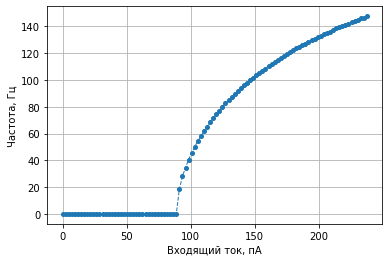

In [102]:
plot(if_group.I/pA, if_mon.count / 2, '--o', lw=1, ms=4)  # divide by 2 seconds

xlabel("Входящий ток, пА")
ylabel("Частота, Гц")
grid()

#savefig("IF-curve.jpeg", dpi=200)